In [1]:
%load_ext jupyternotify
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import functools
import jax
import os
import pandas as pd
import mlflow
import pickle

from datetime import datetime
from jax import numpy as jnp
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output
import mediapy

import brax

import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html

# other envs
from task_aware_skill_composition.brax.envs.point import Point
from task_aware_skill_composition.brax.envs.car import Car
from task_aware_skill_composition.brax.envs.drone import Drone
from task_aware_skill_composition.brax.envs.point import Point
from task_aware_skill_composition.brax.envs.doggo import Doggo
from task_aware_skill_composition.brax.envs.xy_point_maze import XYPointMaze

from task_aware_skill_composition.brax.safety_gymnasium_envs.safety_hopper_velocity_v1 import SafetyHopperVelocityEnv


# tasks
from task_aware_skill_composition.brax.tasks import get_task
from task_aware_skill_composition.brax.cmdp import (
    make_cmdp,
    make_aut_goal_cmdp
)
from task_aware_skill_composition.brax.reward_shaping import (
    make_shaped_reward_mdp,
    make_shaped_reward_mdp2,
    make_aut_goal_mdp
)

mlflow.set_tracking_uri(f"file:///home/tassos/.local/share/mlflow")

2024-12-20 11:21:37.649306: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


# Defining STL

In [3]:
import corallab_stl.expression_jax2 as stl
# import corallab_stl.expression_jax2_extra as stl_extra

# state_var = stl.Var("state", idx=0, dim=37, y_velocity=14)
# # moderate_y_vel = stl_extra.InBox(state_var.y_velocity, jnp.array([0.4]), jnp.array([25.0]))
# # always_moderate_y_vel = stl.STLUntimedAlways(moderate_y_vel)
# # eventually_always_moderate_y_vel = stl.STLUntimedEventually(always_moderate_y_vel)

# true = stl.STLPredicate(state_var, lambda s: 999, lower_bound=0.0)

# high_y_vel = stl.STLPredicate(state_var.y_velocity, lambda s: s[0], lower_bound=1.0)
# always_high_y_vel = stl.STLUntimedAlways(high_y_vel)
# eventually_high_y_vel = stl.STLUntimedEventually(high_y_vel)
# eventually_always_high_y_vel = stl.STLUntimedEventually(always_high_y_vel)

# state_var = stl.Var("state", idx=0, dim=29, position=(0, 2))

# def in_box_pred(x_min, x_max):
#     dim = x_min.shape[0]
#     neg_eye = -jnp.eye(dim)
#     pos_eye = jnp.eye(dim)
#     A = jnp.vstack((neg_eye, pos_eye))
#     b = jnp.concatenate((-x_min, x_max))
        
#     def in_box(s):
#         x = b - jnp.matmul(A, s)
#         return jnp.min(x, axis=-1)

#     return in_box

# in_region_1 = stl.STLPredicate(
#     state_var.position,
#     in_box_pred(jnp.array([3.0, 3.0]), jnp.array([4.0, 4.0])),
#     0.1
# )

# in_region_2 = stl.STLPredicate(
#     state_var.position,
#     in_box_pred(jnp.array([-4.0, 3.0]), jnp.array([-3.0, 4.0])),
#     0.1
# )

# in_region_3 = stl.STLPredicate(
#     state_var.position,
#     in_box_pred(jnp.array([1.5, 1.5]), jnp.array([2.5, 2.5])),
#     0.0
# )

# phi = stl.STLAnd(
#     stl.STLUntimedEventually(
#         stl.STLAnd(
#             in_region_1,
#             stl.STLNext(stl.STLUntimedEventually(in_region_2)),
#         )
#     ),
#     stl.STLUntimedAlways(stl.STLNegation(in_region_3))
# )

# phi({ state_var.idx: jnp.array([[0.0, 0.0],
#                                 [3.0, 0.0],
#                                 [3.5, 3.0],
#                                 [3.5, 3.5],
#                                 [-3.5, 3.5]]) })

# in_region_1 = stl.STLPredicate(state_var.position, lambda s: s

# high_y_vel = stl.STLPredicate(state_var.y_velocity, lambda s: s[0], lower_bound=1.0)
# always_high_y_vel = stl.STLUntimedAlways(high_y_vel)
# eventually_always_high_y_vel = stl.STLUntimedEventually(high_y_vel)

# Defining Env/Task

In [4]:
mlflow.set_experiment("proj2-hierarchy-comparison")

<Experiment: artifact_location='file:///home/tassos/.local/share/mlflow/778019973331947620', creation_time=1731686379807, experiment_id='778019973331947620', last_update_time=1731686379807, lifecycle_stage='active', name='proj2-hierarchy-comparison', tags={}>

In [5]:
backend = 'mjx'

# env = Car(backend=backend)
# env = Drone(backend=backend)
# env = Point(backend=backend)
# env = Doggo(backend=backend)

# env = envs.get_environment(env_name="reacher", backend=backend)
# env = AntMaze(backend=backend)

# task = get_task("point", "one_goal")
# task = get_task("ant_maze", "true")
# task = get_task("simple_maze", "umaze_constraint")
# task = get_task("simple_maze", "two_subgoals")
task = get_task("simple_maze", "subgoal")
# task = get_task("hopper", "straight")
# task = get_task("xy_point", "diagonal1")
# task = get_task("ant", "straight_seq")
env = task.env

spec = task.lo_spec
spec_tag = type(task).__name__
env_tag = type(env).__name__

jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

In [6]:
# env = SafetyHopperVelocityEnv(backend="mjx")
# spec = stl.STLPredicate(stl.Var(name="obs", dim=env.observation_size), lambda s: 999, lower_bound=0.0)
# spec_tag = "SafeVelocity"
# env_tag = "Hopper"

# jit_reset = jax.jit(env.reset)
# jit_step = jax.jit(env.step)

In [7]:
print(spec_tag)
print(spec)
print(env.observation_size)
print(env.action_size)
alg_suffix = ""

SimpleMazeSingleSubgoal
6
2


## Making the Env Automaton Wrapped

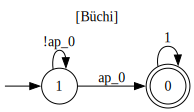

In [8]:
from task_aware_skill_composition.brax.envs.wrappers.automaton_wrapper import AutomatonWrapper
from task_aware_skill_composition.brax.envs.wrappers.automaton_transition_rewards_wrapper import AutomatonTransitionRewardsWrapper
from task_aware_skill_composition.brax.envs.wrappers.automaton_cost_wrapper import AutomatonCostWrapper

cmdp = make_cmdp(task)
cmdp.automaton.automaton

# automaton_wrapped_env = AutomatonWrapper(
#     env,
#     spec,
#     task.obs_var,
#     augment_obs = True
# )

# automaton_wrapped_env = AutomatonCostWrapper(
#     automaton_wrapped_env
# )

# automaton_wrapped_env = AutomatonTransitionRewardsWrapper(
#     automaton_wrapped_env
# )

# alg_suffix = "_with_aut0"
# env = automaton_wrapped_env

# automaton_wrapped_env.automaton.automaton

In [11]:
# print(automaton_wrapped_env.observation_size)
# print(automaton_wrapped_env.action_size)
# alg_suffix = ""

# Plotting Utils

In [12]:
# xdata, ydata = [], []
# times = [datetime.now()]

def progress_fn(num_steps, metrics, **kwargs):
    print(f"Logging for {num_steps}")
    mlflow.log_metrics(metrics, step=num_steps)
    
    # df.loc[num_steps] = {
    #     "time": datetime.now(),
    #     "eval/episode_reward": metrics['eval/episode_reward'],
    #     "eval/episode_robustness": metrics['eval/episode_robustness'] if 'eval/episode_robustness' in metrics else None, 
    #     "training/specification_loss": metrics['training/specification_loss'] if 'training/specification_loss' in metrics else None, 
    # }

# Training

In [13]:
from task_aware_skill_composition.brax.agents.ppo import train as ppo
from task_aware_skill_composition.brax.agents.dscrl import train as dscrl
from task_aware_skill_composition.brax.agents.ppo_with_spec_rewards import train as ppo_spec
from task_aware_skill_composition.brax.agents.hsac import train as hsac

from brax.training.agents.sac import train as sac
from task_aware_skill_composition.brax.agents.sac_lagrangian import train as sac_lagrangian

from task_aware_skill_composition.brax.agents.ddpg import train as ddpg
from task_aware_skill_composition.brax.agents.ddpg_lagrangian import train as ddpg_lagrangian

from task_aware_skill_composition.brax.agents.hdqn import train as hdqn
from task_aware_skill_composition.brax.agents.hdqn_her import train as hdqn_her
from task_aware_skill_composition.brax.agents.hdqn_automaton_her import train as hdqn_automaton_her
from task_aware_skill_composition.brax.agents.hdcqn_her import train as hdcqn_her

from task_aware_skill_composition.brax.agents.sac_her import train as sac_her
from task_aware_skill_composition.brax.agents.sac_her_lagrangian import train as sac_her_lagrangian


def training_run(run_id, env, seed, train_fn=ppo.train, progress_fn=progress_fn, hyperparameters={}, extras={}):
    hyperparameters = {
        **hyperparameters,
        "seed": seed,
    }

    mlflow.log_params(hyperparameters)

    train_fn = functools.partial(train_fn, **hyperparameters)
    
    make_inference_fn, params, _ = train_fn(
        environment=env,
        progress_fn=progress_fn,
        seed=seed,
        **extras
    )

    with mlflow.MlflowClient()._log_artifact_helper(run_id, f'policy_params') as tmp_path:
        model.save_params(tmp_path, params)

    return make_inference_fn, params

## Training Policy with PPO

In [12]:
for seed in range(0, 3):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": "PPO"}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            env,
            seed,
            train_fn=ppo.train,
            hyperparameters=task.ppo_hps,
            extras={
                "specification": spec,
                "state_var": task.obs_var,
            }
        )

E1216 17:37:38.624202 2207176 hlo_lexer.cc:443] Failed to parse int literal: 894515288310727292233


KeyboardInterrupt: 

## Training with Hierarchical PPO

In [ ]:
from task_aware_skill_composition.brax.agents.ppo_option_critic import train as ppo_option_critic
from task_aware_skill_composition.hierarchy.state import OptionState

In [ ]:
from task_aware_skill_composition.hierarchy.xy_point.load import load_xy_point_options, load_hard_coded_xy_point_options

# def adapter(x):
#     return x[..., :-2]

options = load_hard_coded_xy_point_options()
# options = load_xy_point_options() # adapter=adapter)

up [0. 1.]
right [1. 0.]
left [-1.  0.]
down [ 0. -1.]


In [ ]:
# mlflow.set_experiment("proj2-hierarchical-ppo")

for seed in range(0, 3):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": "H_PPO"}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            env,
            seed,
            train_fn=ppo_option_critic.train,
            hyperparameters=task.hppo_hps,
            extras={
                "options": options,
                "specification": spec,
                "state_var": task.obs_var,
            }
        )

Logging for 0
Logging for 5570560
Logging for 11141120
Logging for 16711680
Logging for 22282240
Logging for 27852800
Logging for 33423360
Logging for 38993920
Logging for 44564480
Logging for 50135040
Logging for 0
Logging for 5570560
Logging for 11141120
Logging for 16711680
Logging for 22282240
Logging for 27852800
Logging for 33423360
Logging for 38993920
Logging for 44564480
Logging for 50135040
Logging for 0
Logging for 5570560
Logging for 11141120
Logging for 16711680
Logging for 22282240
Logging for 27852800
Logging for 33423360
Logging for 38993920
Logging for 44564480
Logging for 50135040


## Training with DDPG

In [ ]:
for seed in range(0, 1):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": "DDPG"}) as run:

        print(env_tag)
        print(spec_tag)
        print("DDPG")

        make_inference_fn, params = training_run(
            run.info.run_id,
            env,
            seed,
            train_fn=ddpg.train,
            hyperparameters=task.sac_hps,
            extras={
                # "specification": spec,
                # "state_var": task.obs_var,
            }
        )

SafetyHopperVelocityEnv
HopperStraight
DDPG
Logging for 0
Logging for 142208
Logging for 276224
Logging for 410240
Logging for 544256
Logging for 678272
Logging for 812288
Logging for 946304
Logging for 1080320
Logging for 1214336
Logging for 1348352
Logging for 1482368
Logging for 1616384
Logging for 1750400
Logging for 1884416
Logging for 2018432
Logging for 2152448
Logging for 2286464
Logging for 2420480
Logging for 2554496


## Training with SAC

In [ ]:
for seed in range(0, 1):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": "SAC"}) as run:

        print(env_tag)
        print(spec_tag)
        print(alg_tag)

        make_inference_fn, params = training_run(
            run.info.run_id,
            env,
            seed,
            train_fn=sac.train,
            hyperparameters=task.sac_hps,
            extras={
                # "specification": spec,
                # "state_var": task.obs_var,
            }
        )

SafetyHopperVelocityEnv
HopperStraight
SAC
Logging for 0
Logging for 352768
Logging for 697344
Logging for 1041920
Logging for 1386496
Logging for 1731072
Logging for 2075648
Logging for 2420224
Logging for 2764800
Logging for 3109376
Logging for 3453952
Logging for 3798528
Logging for 4143104
Logging for 4487680
Logging for 4832256
Logging for 5176832
Logging for 5521408
Logging for 5865984
Logging for 6210560
Logging for 6555136


## Training with SAC+HER (from JaxGCRL)

In [ ]:
# sac_hps = {
#     "num_timesteps": 10_000_000,
#     "reward_scaling": 1,
#     "num_evals": 50,
#     "episode_length": 1000,
#     "normalize_observations": True,
#     "action_repeat": 1,
#     "discounting": 0.99,
#     # "learning_rate": 3e-4,
#     "num_envs": 512,
#     "batch_size": 256,
#     "unroll_length": 62,
#     "multiplier_num_sgd_steps": 1,
#     "max_devices_per_host": 1,
#     "max_replay_size": 10000,
#     # 8192, the default, causes the error "TypeError: broadcast_in_dim shape must have every element be nonnegative, got (-2, 50)."
#     "min_replay_size": 1000,
#     "use_her": True,
# }

In [ ]:
# mlflow.set_experiment("proj2-sac-her")

alg_tag = "SAC_HER" + alg_suffix

for seed in range(0, 1):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": alg_tag}) as run:

        print(env_tag)
        print(spec_tag)
        print(alg_tag)

        make_inference_fn, params = training_run(
            run.info.run_id,
            env,
            seed,
            train_fn=sac.train,
            hyperparameters=task.sac_hps,
            extras={
                "specification": spec,
                "state_var": task.obs_var,
            }
        )

SafetyHopperVelocityEnv
HopperStraight
SAC
Num_prefill_actor_steps:  164


2024-11-21 18:29:00.450094: W external/xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 3.09GiB (3322571108 bytes) by rematerialization; only reduced to 14.50GiB (15569256516 bytes), down from 14.50GiB (15569256516 bytes) originally


Logging for 0


2024-11-21 18:29:23.583019: W external/xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below -10.69GiB (-11476223964 bytes) by rematerialization; only reduced to 43.50GiB (46713481588 bytes), down from 43.50GiB (46713481592 bytes) originally
2024-11-21 18:29:35.514165: W external/xla/xla/tsl/framework/bfc_allocator.cc:497] Allocator (GPU_0_bfc) ran out of memory trying to allocate 14.50GiB (rounded to 15569256448)requested by op 
2024-11-21 18:29:35.514896: W external/xla/xla/tsl/framework/bfc_allocator.cc:508] **********************************************************************************__________________
E1121 18:29:35.515095 2665527 pjrt_stream_executor_client.cc:3084] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 15569256448 bytes.


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 15569256448 bytes.

## Training with Hierarchical SAC+HER

In [ ]:
# hsac_hps = {
#     "num_timesteps": 10_000_000,
#     "reward_scaling": 1,
#     "num_evals": 50,
#     "episode_length": 1000,
#     "normalize_observations": True,
#     "action_repeat": 1,
#     "discounting": 0.99,
#     # "learning_rate": 3e-4,
#     "num_envs": 256,
#     "batch_size": 256,
#     "unroll_length": 62,
#     "multiplier_num_sgd_steps": 1,
#     "max_devices_per_host": 1,
#     "max_replay_size": 10000,
#     # 8192, the default, causes the error "TypeError: broadcast_in_dim shape must have every element be nonnegative, got (-2, 50)."
#     "min_replay_size": 1000,
#     "use_her": True,
# }

In [ ]:
from task_aware_skill_composition.hierarchy.xy_point.load import load_xy_point_options, load_hard_coded_xy_point_options
from task_aware_skill_composition.hierarchy.ant.load import load_ant_options

def adapter(x):
    return x[..., 2:-2]

# options = load_hard_coded_xy_point_options()
options = load_ant_options(adapter=adapter)
# options = load_xy_point_options() # adapter=adapter)

In [ ]:
%%notify

alg_tag = "H_SAC" + alg_suffix

for seed in range(0, 1):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": alg_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            env,
            seed,
            train_fn=hsac.train,
            hyperparameters=task.hsac_hps,
            extras={
                "options": options,
                "specification": spec,
                "state_var": task.obs_var,
            }
        )

## Training with HDQN

In [14]:
from task_aware_skill_composition.hierarchy.xy_point.load import load_xy_point_options, load_hard_coded_xy_point_options
# from task_aware_skill_composition.hierarchy.ant.load import load_ant_options

# def adapter(x):
#     return x[..., 2:-2]

options = load_hard_coded_xy_point_options()
# options = load_hard_coded_xy_point_options(termination_prob = 0.25)
# options = load_ant_options(adapter=adapter)
# options = load_xy_point_options() # adapter=adapter)

up [0. 1.]
right [1. 0.]
left [-1.  0.]
down [ 0. -1.]


In [40]:
alg_tag = "HDQN"

for seed in range(0, 1):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": alg_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            env,
            seed,
            train_fn=hdqn.train,
            hyperparameters=task.hdqn_hps,
            extras={
                "options": options,
                "specification": spec,
                "state_var": task.obs_var,
            }
        )

Logging for 0
Logging for 534144
Logging for 1060096
Logging for 1586048
Logging for 2112000
Logging for 2637952
Logging for 3163904
Logging for 3689856
Logging for 4215808
Logging for 4741760
Logging for 5267712
Logging for 5793664
Logging for 6319616
Logging for 6845568
Logging for 7371520
Logging for 7897472
Logging for 8423424
Logging for 8949376
Logging for 9475328
Logging for 10001280


## Training with HDQN-HER

### Training with Basic HDQN-HER

In [ ]:
alg_tag = "HDQN_HER_BASE"

for seed in range(0, 1):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": alg_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            env,
            seed,
            train_fn=hdqn_her.train,
            hyperparameters=task.hdqn_her_hps,
            extras={
                "options": options,
                "specification": spec,
                "state_var": task.obs_var,
            }
        )

### Training with HDQN-HER for a Reward Shaped Automaton

In [ ]:
alg_tag = "HDQN_HER_STEEPER_REWARD_SHAPING"

for seed in range(0, 3):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": alg_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            make_shaped_reward_mdp(task, 15),
            seed,
            train_fn=hdqn_her.train,
            hyperparameters=task.hdqn_her_hps,
            extras={
                "options": options,
                "specification": spec,
                "state_var": task.obs_var,
            }
        )

### Training with HDQN-Automaton-HER 

In [15]:
from task_aware_skill_composition.visualization.critic import make_plots_for_hdqn

def hdqn_progress_fn(num_steps, metrics, df=None, **kwargs):
    print(f"Logging for {num_steps}")
    mlflow.log_metrics(metrics, step=num_steps)

    env = kwargs["env"]
    network = kwargs["network"]
    params = kwargs["params"]

    make_plots_for_hdqn(
      env=env,
      network=network,
      params=params,
      label=f"state 1 - {num_steps}",
    )

    make_plots_for_hdqn(
      env=env,
      network=network,
      params=params,
      label=f"state 0 - {num_steps}",
      tmp_state_fn=lambda x: x.replace(obs=x.obs.at[6:].set(env.automaton.one_hot_encode(jnp.int32(0)))),
    )


In [16]:
alg_tag = "HDQN_HER_SIMPLE_AUTOMATON_HER"

for seed in range(1, 2):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": alg_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            make_aut_goal_mdp(task),
            seed,
            train_fn=hdqn_automaton_her.train,
            progress_fn=hdqn_progress_fn,
            hyperparameters=task.hdqn_her_hps,
            extras={
                # "normalization_mask": normalization_mask,
                "options": options,
                "specification": spec,
                "state_var": task.obs_var,
                # "replay_buffer_class_name": "SimpleAutomatonTrajectoryUniformSamplingQueue",
            }
        )

Num_prefill_actor_steps:  17
Logging for 0
Logging for 476160
Logging for 682496
Logging for 888832
Logging for 1095168
Logging for 1301504
Logging for 1507840
Logging for 1714176
Logging for 1920512
Logging for 2126848
Logging for 2333184
Logging for 2539520
Logging for 2745856
Logging for 2952192
Logging for 3158528
Logging for 3364864
Logging for 3571200
Logging for 3777536
Logging for 3983872
Logging for 4190208
Logging for 4396544
Logging for 4602880
Logging for 4809216
Logging for 5015552
Logging for 5221888
Logging for 5428224
Logging for 5634560
Logging for 5840896
Logging for 6047232
Logging for 6253568
Logging for 6459904
Logging for 6666240
Logging for 6872576
Logging for 7078912
Logging for 7285248
Logging for 7491584
Logging for 7697920
Logging for 7904256
Logging for 8110592
Logging for 8316928
Logging for 8523264
Logging for 8729600
Logging for 8935936
Logging for 9142272
Logging for 9348608
Logging for 9554944
Logging for 9761280
Logging for 9967616
Logging for 10173952

In [ ]:
alg_tag = "HDQN_HER_FULL_AUTOMATON_HER"

for seed in range(1, 2):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": alg_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            make_shaped_reward_mdp2(task, 1),
            seed,
            train_fn=hdqn_her.train,
            progress_fn=hdqn_progress_fn,
            hyperparameters=task.hdqn_her_hps,
            extras={
                # "normalization_mask": normalization_mask,
                "options": options,
                "specification": spec,
                "state_var": task.obs_var,
                "replay_buffer_class_name": "AutomatonTrajectoryUniformSamplingQueue",
            }
        )

## Training with HDCQN-HER

In [13]:
alg_tag = "HDCQN_HER"

for seed in range(1, 2):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": alg_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            make_cmdp(task),
            seed,
            train_fn=hdcqn_her.train,
            hyperparameters=task.hdcqn_her_hps,
            extras={
                "options": options,
                "specification": spec,
                "state_var": task.obs_var,
            }
        )

Num_prefill_actor_steps:  17
Logging for 0
Logging for 476160
Logging for 682496
Logging for 888832
Logging for 1095168
Logging for 1301504
Logging for 1507840
Logging for 1714176
Logging for 1920512
Logging for 2126848
Logging for 2333184
Logging for 2539520
Logging for 2745856
Logging for 2952192
Logging for 3158528
Logging for 3364864
Logging for 3571200
Logging for 3777536
Logging for 3983872
Logging for 4190208
Logging for 4396544
Logging for 4602880
Logging for 4809216
Logging for 5015552
Logging for 5221888
Logging for 5428224
Logging for 5634560
Logging for 5840896
Logging for 6047232
Logging for 6253568
Logging for 6459904
Logging for 6666240
Logging for 6872576
Logging for 7078912
Logging for 7285248
Logging for 7491584
Logging for 7697920
Logging for 7904256
Logging for 8110592
Logging for 8316928
Logging for 8523264
Logging for 8729600
Logging for 8935936
Logging for 9142272
Logging for 9348608
Logging for 9554944
Logging for 9761280
Logging for 9967616
Logging for 10173952

In [ ]:
alg_tag = "HDCQN_HER_SIMPLE_AUTOMATON_HER"

for seed in range(1, 2):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": alg_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            make_aut_goal_cmdp(task),
            seed,
            train_fn=hdqn_automaton_her.train,
            hyperparameters=task.hdqn_her_hps,
            extras={
                # "normalization_mask": normalization_mask,
                "options": options,
                "specification": spec,
                "state_var": task.obs_var,
                # "replay_buffer_class_name": "SimpleAutomatonTrajectoryUniformSamplingQueue",
            }
        )

## Training with SAC-Lagrangian

In [21]:
%%notify

alg_tag = "SAC_LAGRANGIAN"

for seed in range(0, 1):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": alg_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            env, # automaton_wrapped_env,
            seed,
            train_fn=sac_lagrangian.train,
            hyperparameters=task.sac_hps,
            extras={
                # "options": options,
                # "specification": spec,
                # "state_var": task.obs_var,
            }
        )

Logging for 0
Logging for 352768
Logging for 697344
Logging for 1041920
Logging for 1386496
Logging for 1731072
Logging for 2075648
Logging for 2420224
Logging for 2764800
Logging for 3109376
Logging for 3453952
Logging for 3798528
Logging for 4143104
Logging for 4487680
Logging for 4832256
Logging for 5176832
Logging for 5521408
Logging for 5865984
Logging for 6210560
Logging for 6555136


<IPython.core.display.Javascript object>

## Training with DDPG-Lagrangian

In [19]:
%%notify

alg_tag = "DDPG_LAGRANGIAN"

for seed in range(1, 3):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": alg_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            env,
            seed,
            train_fn=ddpg_lagrangian.train,
            hyperparameters=task.ddpg_hps,
            extras={
                # "options": options,
                # "specification": spec,
                # "state_var": task.obs_var,
            }
        )

Logging for 0
Logging for 86784
Logging for 165376
Logging for 243968
Logging for 322560
Logging for 401152
Logging for 479744
Logging for 558336
Logging for 636928
Logging for 715520
Logging for 794112
Logging for 872704
Logging for 951296
Logging for 1029888
Logging for 1108480
Logging for 1187072
Logging for 1265664
Logging for 1344256
Logging for 1422848
Logging for 1501440
Logging for 0
Logging for 86784
Logging for 165376
Logging for 243968
Logging for 322560
Logging for 401152
Logging for 479744
Logging for 558336
Logging for 636928
Logging for 715520
Logging for 794112
Logging for 872704
Logging for 951296
Logging for 1029888
Logging for 1108480
Logging for 1187072
Logging for 1265664
Logging for 1344256
Logging for 1422848
Logging for 1501440


<IPython.core.display.Javascript object>

## Training Policy with PPO + STL Rewards

In [12]:
from task_aware_skill_composition.brax.envs.wrappers.specification_reward_wrapper import SpecificationRewardWrapper

In [15]:
# mlflow.set_experiment("proj2-ppo-spec")

spec_wrapped_env = SpecificationRewardWrapper(
    env,
    spec,
    task.obs_var,
    rho_weight=1.0
)

for seed in range(0, 3):
    with mlflow.start_run(tags={"alg": "ppo_spec", "env": env_tag, "spec": spec_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            spec_wrapped_env,
            seed,
            train_fn=ppo.train,
            hyperparameters={**task.ppo_hps, "num_timesteps": 10_000_000},
            extras={
                "specification": spec,
                "state_var": task.obs_var,
            }
        )

Logging for 0
Logging for 655360
Logging for 1310720
Logging for 1966080
Logging for 2621440
Logging for 3276800
Logging for 3932160
Logging for 4587520
Logging for 5242880
Logging for 5898240
Logging for 6553600
Logging for 7208960
Logging for 7864320
Logging for 8519680
Logging for 9175040
Logging for 9830400
Logging for 10485760
Logging for 11141120
Logging for 11796480
Logging for 11141120
Logging for 11796480
Logging for 12451840
Logging for 0
Logging for 4587520
Logging for 10485760
Logging for 11141120
Logging for 11796480
Logging for 12451840


## Training Policy with PPO + Automaton State

In [28]:
normalization_mask = jnp.array([1] * task.obs_var.dim + [0] * automaton_wrapped_env.automaton.n_states, dtype=jnp.uint8)

In [81]:
mlflow.set_experiment("proj2-ppo-automaton")

for seed in range(0, 3):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            automaton_wrapped_env,
            seed,
            train_fn=ppo.train,
            hyperparameters={**task.ppo_hps, "num_timesteps": 50_000_000},
            extras={
                "normalization_mask": normalization_mask,
                "specification": spec,
                "state_var": task.obs_var,
            }
        )

Logging for 0
Logging for 2949120
Logging for 5898240
Logging for 8847360
Logging for 11796480
Logging for 14745600
Logging for 17694720
Logging for 20643840
Logging for 23592960
Logging for 26542080
Logging for 29491200
Logging for 32440320
Logging for 35389440
Logging for 38338560
Logging for 41287680
Logging for 44236800
Logging for 47185920
Logging for 50135040
Logging for 53084160
Logging for 56033280


## Training with PPO + Automaton Transition Rewards

In [ ]:
mlflow.set_experiment("proj2-ppo-automaton-rewards")

for seed in range(1, 3):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            automaton_wrapped_env,
            seed,
            train_fn=ppo.train,
            hyperparameters={**task.ppo_hps, num_timesteps=10_000_000},
            extras={
                "specification": spec,
                "state_var": task.obs_var,
            }
        )

Logging for 0
Logging for 10813440
Logging for 21626880
Logging for 32440320
Logging for 43253760
Logging for 54067200
Logging for 64880640
Logging for 75694080
Logging for 86507520
Logging for 97320960
Logging for 108134400
Logging for 118947840
Logging for 129761280
Logging for 140574720
Logging for 151388160
Logging for 162201600
Logging for 173015040
Logging for 183828480
Logging for 194641920
Logging for 205455360
Logging for 0
Logging for 10813440
Logging for 21626880
Logging for 32440320
Logging for 43253760
Logging for 54067200
Logging for 64880640
Logging for 75694080
Logging for 86507520
Logging for 97320960
Logging for 108134400
Logging for 118947840
Logging for 129761280
Logging for 140574720
Logging for 151388160
Logging for 162201600
Logging for 173015040
Logging for 183828480
Logging for 194641920
Logging for 205455360


## Training with CRL

In [11]:
crl_hps = {
    "num_timesteps": 10_000_000,
    "max_replay_size": 10_000,
    "min_replay_size": 1_000,
    "num_evals": 50,
    "episode_length": 1000,
    "action_repeat": 1,
    "discounting": 0.99,
    "num_envs": 512,
    "batch_size": 256,
    "unroll_length": 62,
    "multiplier_num_sgd_steps": 1,
    # "env_name": "reacher",
    "normalize_observations": False,
    "policy_lr": 6e-4,
    "alpha_lr": 3e-4,
    "critic_lr": 3e-4,
    "contrastive_loss_fn": 'infonce_backward',
    "energy_fn": 'l2',
    # "backend": None,
    # "no_resubs": False,
    "use_ln": False,
    "use_c_target": False,
    "logsumexp_penalty": 0.0,
    "l2_penalty": 0.0,
    "exploration_coef": 0.0,
    "random_goals": 0.0,
    # "log_wandb": False,
    "disable_entropy_actor": False,
    "eval_env": None,
    "h_dim": 256,
    "n_hidden": 2,
    "repr_dim": 64,
}

In [12]:
from jaxgcrl import train as crl

In [13]:
for seed in range(0, 1):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": "CRL"}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            env,
            seed,
            train_fn=crl.train,
            hyperparameters=crl_hps,
            # extras={
            #     "specification": spec,
            #     "state_var": task.obs_var,
            # }
        )

Num_prefill_actor_steps:  17
Logging for 0
Logging for 761856
Logging for 984064
Logging for 1206272
Logging for 1428480
Logging for 1650688
Logging for 1872896
Logging for 2095104
Logging for 2317312
Logging for 2539520
Logging for 2761728
Logging for 2983936
Logging for 3206144
Logging for 3428352
Logging for 3650560
Logging for 3872768
Logging for 4094976
Logging for 4317184
Logging for 4539392
Logging for 4761600
Logging for 4983808
Logging for 5206016
Logging for 5428224
Logging for 5650432
Logging for 5872640
Logging for 6094848
Logging for 6317056
Logging for 6539264
Logging for 6761472
Logging for 6983680
Logging for 7205888
Logging for 7428096
Logging for 7650304
Logging for 7872512
Logging for 8094720
Logging for 8316928
Logging for 8539136
Logging for 8761344
Logging for 8983552
Logging for 9205760
Logging for 9427968
Logging for 9650176
Logging for 9872384
Logging for 10094592
Logging for 10316800
Logging for 10539008
Logging for 10761216
Logging for 10983424
Logging for 11

# Visualizing Policy

## Loading from a previous run

In [31]:
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.sac import networks as sac_networks
from task_aware_skill_composition.hierarchy.option_critic import networks as oc_networks
from task_aware_skill_composition.brax.agents.hsac import networks as hsac_networks
from task_aware_skill_composition.brax.agents.hdqn import networks as hdq_networks
from task_aware_skill_composition.brax.agents.hdcqn import networks as hdcq_networks
from jaxgcrl.src import networks as crl_networks
from brax.training.acme import running_statistics

In [32]:
training_run_id = "e3801dc97e784cc5949420c362cd2a84"
logged_model_path = f'runs:/{training_run_id}/policy_params'
real_path = mlflow.artifacts.download_artifacts(logged_model_path)
params = model.load_params(real_path)
# normalizer_params, policy_params = model.load_params(real_path)
# normalizer_params, policy_params, crl_critic_params = model.load_params(real_path)

In [33]:
run = mlflow.get_run(run_id=training_run_id)
if run.data.params["normalize_observations"] == "True":
    normalize = running_statistics.normalize
else:
    normalize = lambda x, y: x

In [34]:
# # Making the network
# ppo_network = ppo_networks.make_ppo_networks(
#       state.obs.shape[0],
#       env.action_size,
#       preprocess_observations_fn=normalize
# )
# make_policy = ppo_networks.make_inference_fn(ppo_network)

# # Making the network
# oc_network = oc_networks.make_option_critic_networks(
#       state.obs.shape[0],
#       env.action_size,
#       options=options,
#       preprocess_observations_fn=normalize,
# )
# make_policy = oc_networks.make_inference_fn(oc_network)

# # Making the network
# hsac_network = hsac_networks.make_soac_networks(
#       env.observation_size,
#       env.action_size,
#       options=options,
#       preprocess_observations_fn=normalize,
# )
# make_policy = hsac_networks.make_inference_fn(hsac_network)

hdq_network = hdq_networks.make_hdq_networks(
      env.observation_size,
      env.action_size,
      options=options,
      preprocess_observations_fn=normalize,
)
make_policy = hdq_networks.make_inference_fn(hdq_network)

# hdcq_network = hdcq_networks.make_hdcq_networks(
#       env.observation_size,
#       env.action_size,
#       options=options,
#       preprocess_observations_fn=normalize,
# )
# make_policy = hdcq_networks.make_inference_fn(hdcq_network, task.hdcqn_her_hps["cost_budget"])

# # Making the network
# sac_network = sac_networks.make_sac_networks(
#       env.observation_size,
#       env.action_size,
#       preprocess_observations_fn=normalize,
# )
# make_policy = sac_networks.make_inference_fn(sac_network)

# # Making the network
# crl_network = crl_networks.make_crl_networks(
#     env=env,
#     observation_size=env.observation_size,
#     action_size=env.action_size,
#     # repr_dim=run.data.params["repr_dim"],
#     preprocess_observations_fn=normalize,
#     hidden_layer_sizes=[int(run.data.params["h_dim"])] * int(run.data.params["n_hidden"]),
#     use_ln=bool(run.data.params["use_ln"]),
# )
# make_policy = crl_networks.make_inference_fn(crl_network)

## Or from the most recent run from the current session

In [ ]:
make_policy = make_inference_fn

In [41]:
inference_fn = make_policy(params, deterministic=True)
jit_inference_fn = jax.jit(inference_fn)

### Without Options

In [ ]:
from task_aware_skill_composition.visualization.flat import get_rollout

rollout, actions = get_rollout(env, jit_inference_fn, n_steps=800, render_every=1, seed=1)

In [18]:
mediapy.write_video(
    "./safe_hopper.mp4",
    env.render(
        [s.pipeline_state for s in rollout],
        camera='track'
    ), fps=1.0 / env.dt
)

mediapy.show_video(
    env.render(
        [s.pipeline_state for s in rollout],
        camera='track'
    ), fps=1.0 / env.dt
)

### With Options

In [19]:
from task_aware_skill_composition.visualization.hierarchy import get_rollout

# rollout, opt_traj, action = get_rollout(make_shaped_reward_mdp2(task, 1), jit_inference_fn, options, n_steps=300, seed=3, render_every=1)
rollout, opt_traj, action = get_rollout(make_cmdp(task), jit_inference_fn, options, n_steps=300, seed=3, render_every=1)
# rollout, opt_traj, action = get_rollout(env, jit_inference_fn, options, n_steps=600, seed=4, render_every=1)

In [ ]:
# mediapy.show_video(
mediapy.write_video('./rollout.mp4',
    env.render(
        [s.pipeline_state for s in rollout],
        camera='overview'
    ), fps=1.0 / env.dt
)

In [51]:
# opt_traj

In [52]:
options[3].termination_policy.p

1.0

## TEST

In [ ]:
HTML(html.render(env.sys, [state.pipeline_state for state in rollout]))

In [27]:
obs_traj = jnp.stack([state.obs for state in rollout])
position_traj = jnp.stack([state.obs[:2] for state in rollout])
reward_traj = jnp.stack([state.reward for state in rollout])
# option_traj = jnp.stack(options)

#from jax.numpy.linalg import norm

# print(norm(position_traj - jnp.array([2.0, 0.0]), axis=1))
# print(delta_good_edge_satisfaction_state_traj)
# automaton_wrapped_env.automaton.one_hot_decode(observations[:, -3:])

In [28]:
rollout[0].info

{'automata_state': Array(1, dtype=uint32),
 'made_transition': Array(0, dtype=uint32),
 'seed': Array(0, dtype=int32, weak_type=True)}

In [ ]:
cost_traj = jnp.stack([state.info["cost"] for state in rollout])

In [56]:
cost_traj.sum()

Array(-441.12817, dtype=float32)

In [38]:
# task.lo_spec(jnp.expand_dims(obs_traj, 0))
# obs_traj.shape

In [42]:
rollout[1].info

{'automata_state': Array(1, dtype=uint32),
 'delta_good_edge_satisfaction': Array(0.00260377, dtype=float32),
 'good_edge_satisfaction': Array(-1.0035887, dtype=float32),
 'made_transition': Array(0, dtype=uint32)}

In [33]:
automata_state_traj = jnp.stack([state.info["automata_state"] for state in rollout])
made_transition_traj = jnp.stack([state.info["made_transition"] for state in rollout])
# good_edge_satisfaction_state_traj = jnp.stack([state.info["good_edge_satisfaction"] for state in rollout])
# delta_good_edge_satisfaction_state_traj = jnp.stack([state.info["delta_good_edge_satisfaction"] for state in rollout])

In [34]:
automata_state_traj

Array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

# Visualizing Q Function 1

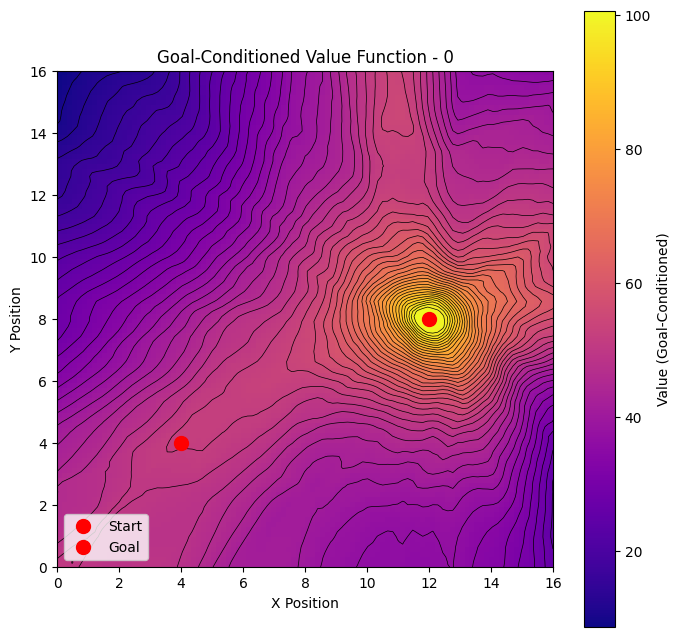

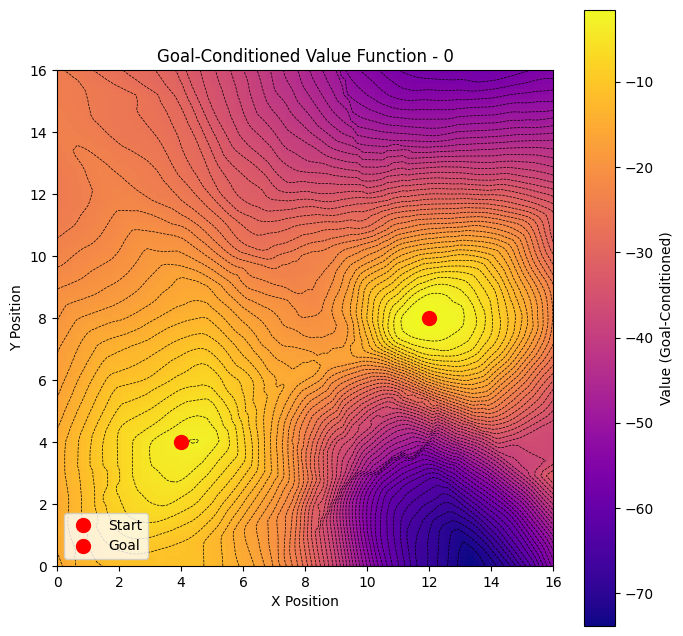

In [66]:
from task_aware_skill_composition.brax.agents.hdcqn import networks as hdcq_networks
from task_aware_skill_composition.visualization.critic import make_plots_for_hdcqn
from brax.training.acme import running_statistics

# normalize = lambda x, y: x
normalize = running_statistics.normalize

hdcq_network = hdcq_networks.make_hdcq_networks(
      env.observation_size,
      env.action_size,
      options=options,
      preprocess_observations_fn=normalize,
)
make_policy = hdcq_networks.make_option_inference_fn(hdcq_network, task.hdcqn_her_hps["cost_budget"])

plot1, plot2 = make_plots_for_hdcqn(
        make_cmdp(task),
        make_policy,
        hdcq_network,
        params,
        0,
)

# Visualizing Q Function 2

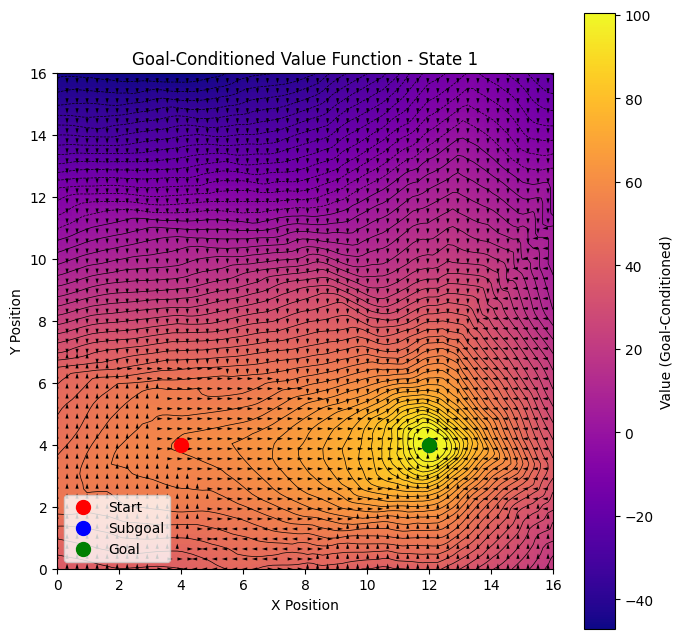

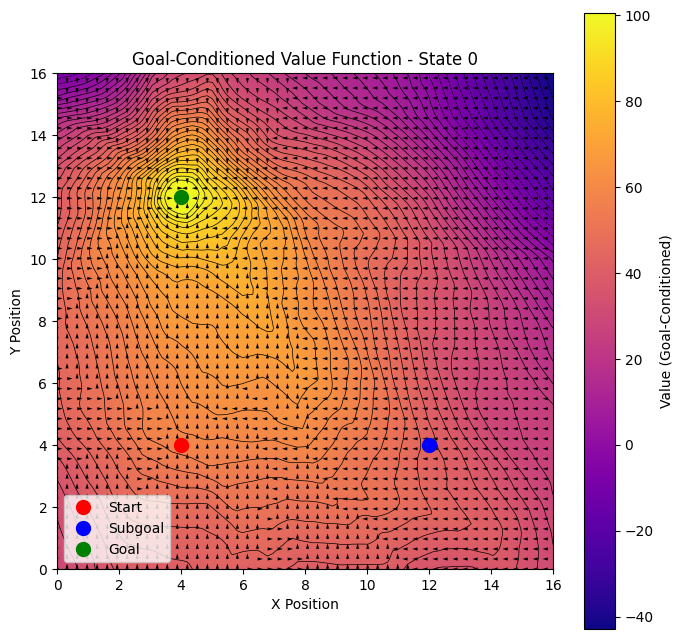

In [36]:
from task_aware_skill_composition.brax.agents.hdqn import networks as hdq_networks
from task_aware_skill_composition.visualization.critic import make_plots_for_hdqn
from task_aware_skill_composition.brax.training.acme import running_statistics

# normalize = lambda x, y: x
# normalize = running_statistics.normalize
# normalize = functools.partial(running_statistics.normalize, mask=normalization_mask)

tmp_env = make_aut_goal_mdp(task)
seed=0

plot1 = make_plots_for_hdqn(
        tmp_env,
        hdq_network,
        params,
        "State 1",
        seed=seed,
        # tmp_state_fn=lambda x: x.replace(obs=x.obs.at[6:].set(jnp.concatenate((jnp.array([4.0, 12.0]), tmp_env.automaton.one_hot_encode(jnp.int32(0))))),
        save_and_close=False,
)

# state_zero_suffix = jnp.concatenate((jnp.array([4.0, 12.0]), tmp_env.automaton.one_hot_encode(jnp.int32(1))))
state_zero_suffix = jnp.array([4.0, 12.0])

plot2 = make_plots_for_hdqn(
        tmp_env,
        hdq_network,
        params,
        "State 0",
        seed=seed,
        tmp_state_fn=lambda x: x.replace(obs=x.obs.at[4:].set(state_zero_suffix)),
        # tmp_state_fn=lambda x: x.replace(obs=x.obs.at[8:].set(tmp_env.automaton.one_hot_encode(jnp.int32(0)))),
        save_and_close=False,
)